In [1]:
import numpy as np
import pandas as pd
import os
import librosa
from scipy.signal import lfilter
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.optimizers import RMSprop

import seaborn as sns
import librosa.display
from IPython.display import Audio
import warnings
from lime import lime_tabular
warnings.filterwarnings('ignore')

In [2]:
def extract_cqt(audio, sr):
    cqt = librosa.cqt(audio, sr=sr)
    cqt_db = librosa.amplitude_to_db(np.abs(cqt), ref=np.max)
    return cqt_db

In [3]:
def rasta_filtering(signal):
    pole = 0.94  # RASTA filter pole
    filtered_signal = np.zeros_like(signal)
    
    for i in range(signal.shape[0]):
        for j in range(1, signal.shape[1]):
            filtered_signal[i, j] = signal[i, j] - pole * signal[i, j - 1]
    return filtered_signal

In [4]:
def extract_features(audio_path):
    audio, sr = librosa.load(audio_path, sr=None)
    mfcc_features = librosa.feature.mfcc(y=audio, sr=sr)
    rasta_filtered_mfcc = rasta_filtering(mfcc_features)
    cqt_features = extract_cqt(audio, sr)
    combined_features = np.vstack([mfcc_features, cqt_features, rasta_filtered_mfcc])
    return combined_features

In [5]:
paths = []
labels = []
data = []

for dirname, _, filenames in os.walk(r"C:\Users\adhin\OneDrive\Desktop\SER\TESS Toronto emotional speech set data"):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
        wav_file_name = os.path.join(dirname, filename)
        data.append(extract_features(wav_file_name))
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [6]:
data

[array([[-6.1680695e+02, -5.7298529e+02, -4.8713040e+02, ...,
         -5.2411780e+02, -5.6780914e+02, -6.0426044e+02],
        [ 1.2440691e+01, -1.2052870e+01, -4.0686665e+01, ...,
          4.7080528e+01,  3.8278118e+01,  2.1402103e+01],
        [ 1.2140997e+01,  6.3441448e+00,  1.0024566e+01, ...,
         -2.5413006e+01, -2.2603967e+00,  8.4120522e+00],
        ...,
        [ 0.0000000e+00,  8.8163719e+00,  2.2875628e+00, ...,
         -3.8892789e+00, -3.5773799e-01,  2.7648370e+00],
        [ 0.0000000e+00,  1.1875643e+00,  6.4249096e+00, ...,
         -3.4269912e+00,  6.8505540e+00,  6.2402315e+00],
        [ 0.0000000e+00, -1.0461438e+00,  9.1728532e-01, ...,
         -3.7148993e+00,  5.3616147e+00,  4.1604118e+00]], dtype=float32),
 array([[-6.8342023e+02, -6.5961798e+02, -5.7365442e+02, ...,
         -6.1919873e+02, -6.3585999e+02, -6.5061298e+02],
        [ 1.9036978e+01, -2.0157363e+00, -2.8792263e+01, ...,
          7.2381958e+01,  5.7018417e+01,  4.6075607e+01],
        [ 

In [7]:
len(paths)

2795

In [8]:
label_encoder = LabelEncoder()
label_integer_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(label_integer_encoded)

In [9]:
labels_categorical

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [10]:
labelsall = list(set(labels))
labelsall

['neutral', 'angry', 'ps', 'fear', 'disgust', 'happy', 'sad']

In [11]:
max_features = max(seq.shape[1] for seq in data if len(seq.shape) > 1)

# Pad each sequence to ensure uniform feature dimensions
aligned_data = []
for seq in data:
    if seq.shape[1] < max_features:
        # Pad feature dimension with zeros if needed
        padded_seq = np.pad(seq, ((0, 0), (0, max_features - seq.shape[1])), 'constant')
        aligned_data.append(padded_seq)
    else:
        aligned_data.append(seq)

# Now apply pad_sequences to get a consistent time dimension
padded_data = pad_sequences(aligned_data, padding='post', dtype='float32')

# Convert the padded data to a NumPy array if needed
data_array = np.asarray(padded_data)
print(max_features)

284


In [12]:
print(len(data_array))
data_array

2795


array([[[-6.1680695e+02, -5.7298529e+02, -4.8713040e+02, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.2440691e+01, -1.2052870e+01, -4.0686665e+01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.2140997e+01,  6.3441448e+00,  1.0024566e+01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [ 0.0000000e+00,  8.8163719e+00,  2.2875628e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  1.1875643e+00,  6.4249096e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00, -1.0461438e+00,  9.1728532e-01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[-6.8342023e+02, -6.5961798e+02, -5.7365442e+02, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.9036978e+01, -2.0157363e+00, -2.8792263e+01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.8517361e+01, 

In [13]:
paths[:5]

['C:\\Users\\adhin\\OneDrive\\Desktop\\SER\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav',
 'C:\\Users\\adhin\\OneDrive\\Desktop\\SER\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav',
 'C:\\Users\\adhin\\OneDrive\\Desktop\\SER\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav',
 'C:\\Users\\adhin\\OneDrive\\Desktop\\SER\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav',
 'C:\\Users\\adhin\\OneDrive\\Desktop\\SER\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']

In [14]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

In [15]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

speech  label
0  C:\Users\adhin\OneDrive\Desktop\SER\TESS Toron...  angry
1  C:\Users\adhin\OneDrive\Desktop\SER\TESS Toron...  angry
2  C:\Users\adhin\OneDrive\Desktop\SER\TESS Toron...  angry
3  C:\Users\adhin\OneDrive\Desktop\SER\TESS Toron...  angry
4  C:\Users\adhin\OneDrive\Desktop\SER\TESS Toron...  angry

In [16]:
df['label'].value_counts()

label
angry      400
disgust    400
happy      400
neutral    400
ps         400
sad        400
fear       395
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

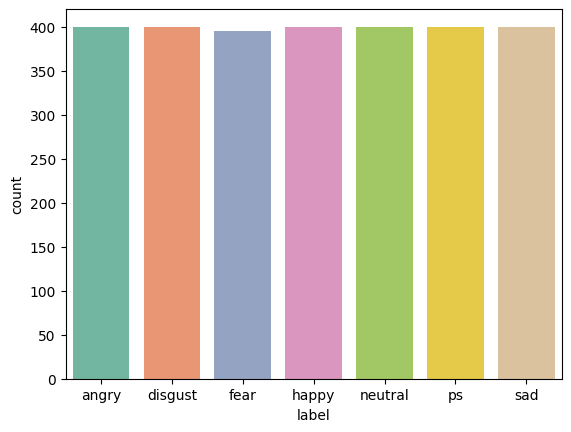

In [17]:
sns.countplot(data=df, x='label', palette='Set2')

In [18]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

def cqt_spectogram(audio, emotion):
    y, sr = librosa.load(audio)
    cqt = librosa.cqt(y, sr=sr)
    cqt_db = librosa.amplitude_to_db(abs(cqt))
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(cqt_db, sr=sr, x_axis='time', y_axis='cqt_hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Constant-Q Transform (CQT) Spectrogram for '+emotion)
    plt.tight_layout()
    plt.show()

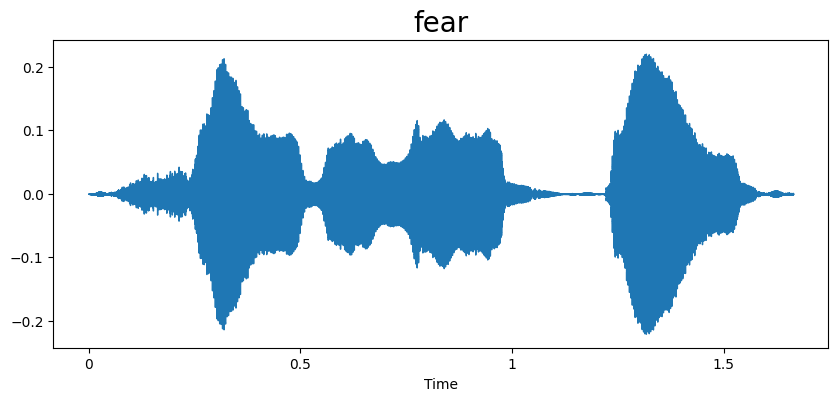

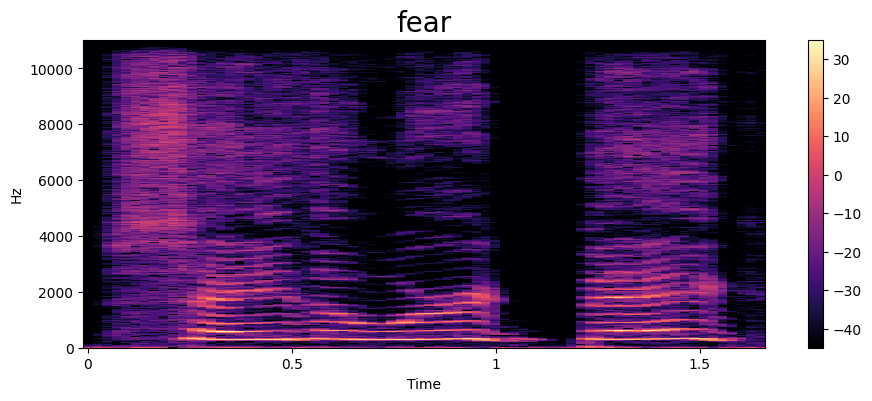

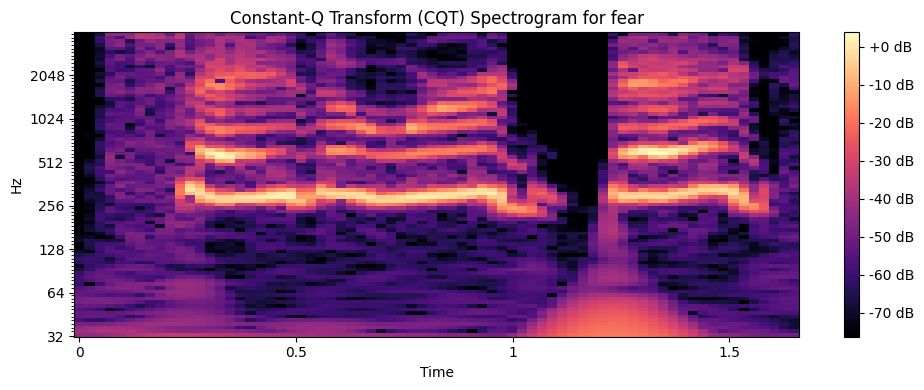

In [19]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
cqt_spectogram(path, emotion)
Audio(path)

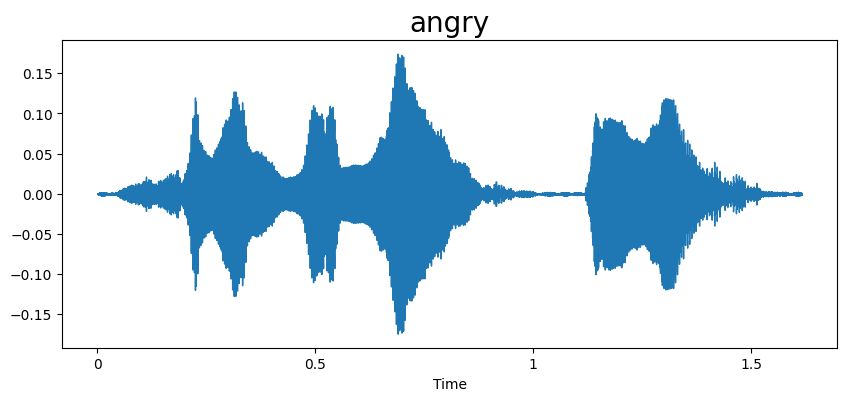

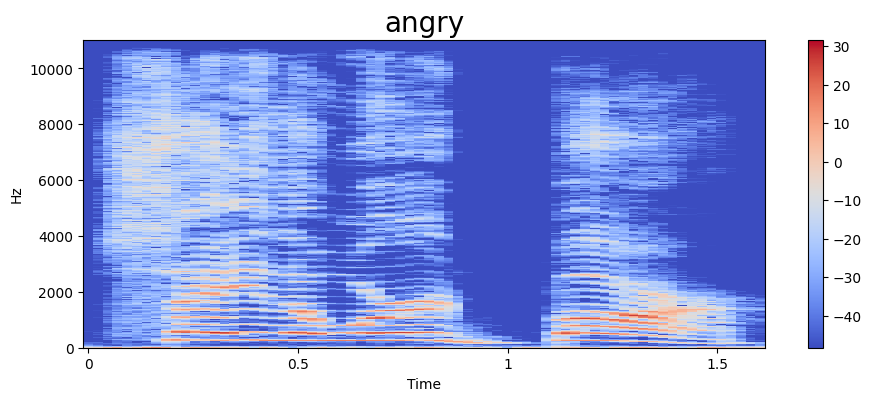

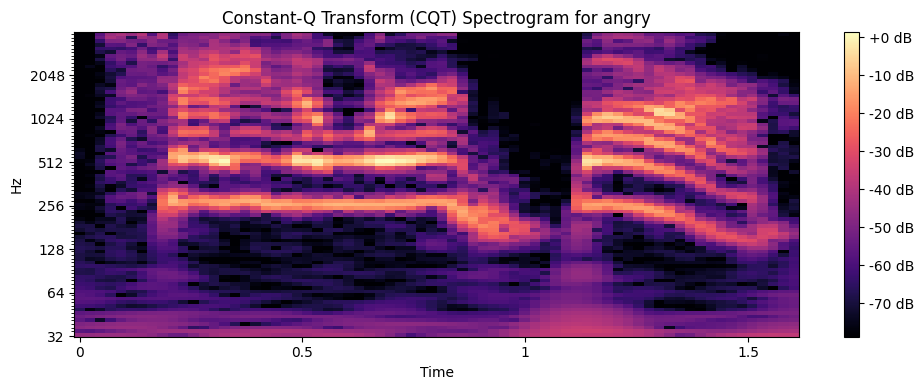

In [20]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
cqt_spectogram(path, emotion)
Audio(path)

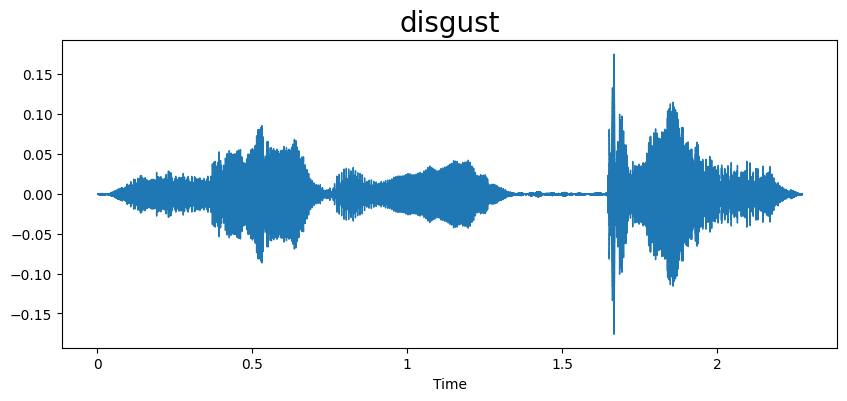

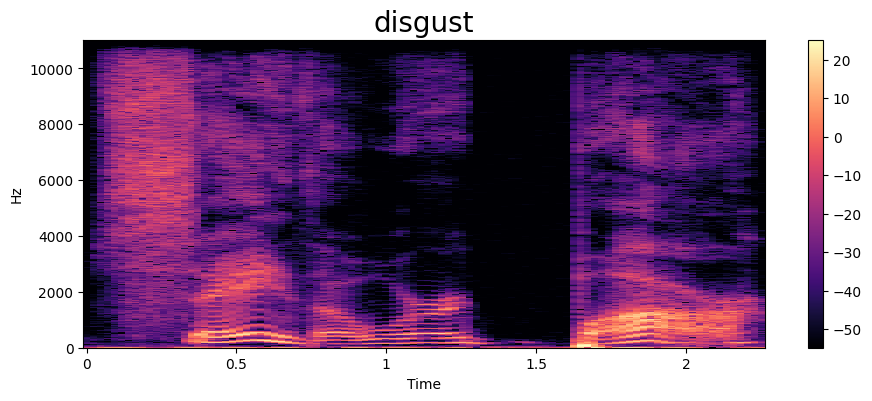

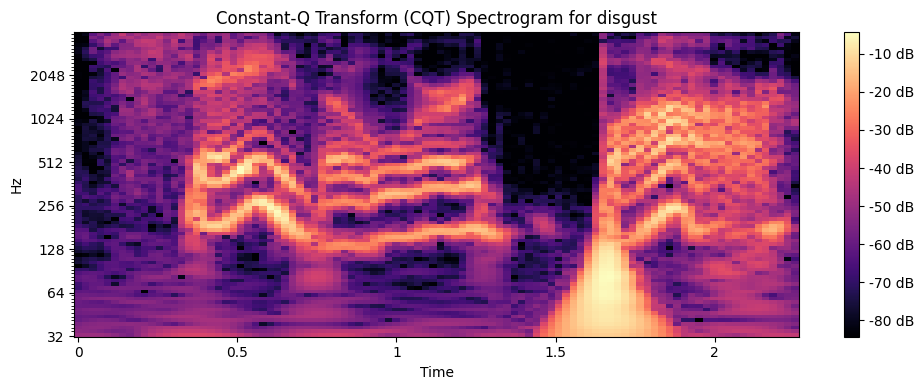

In [21]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
cqt_spectogram(path, emotion)
Audio(path)

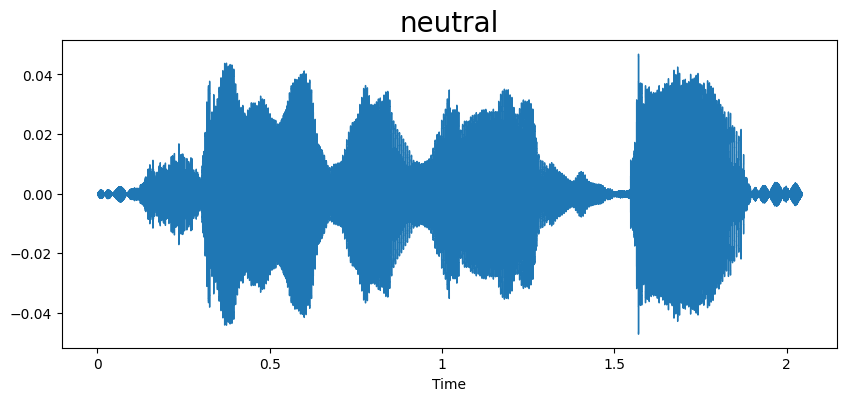

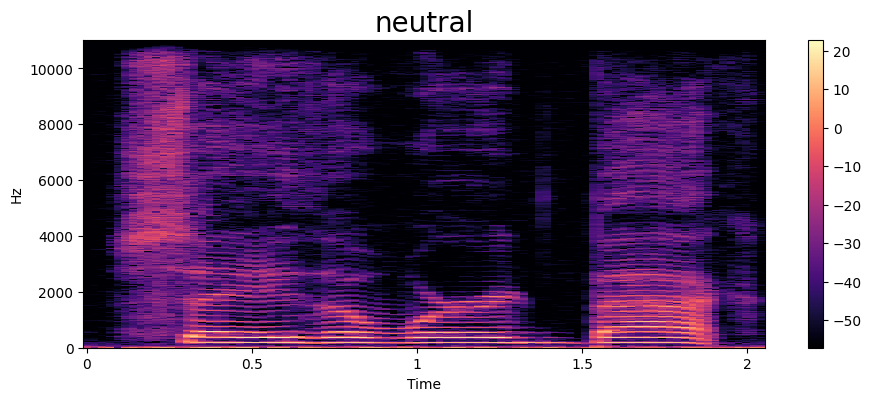

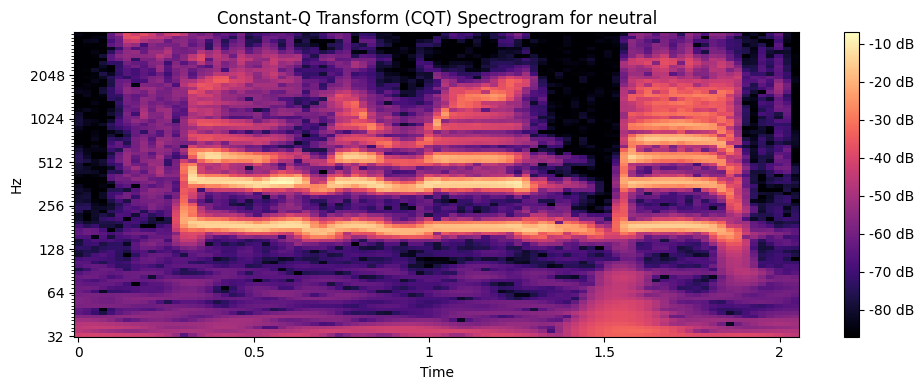

In [22]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
cqt_spectogram(path, emotion)
Audio(path)

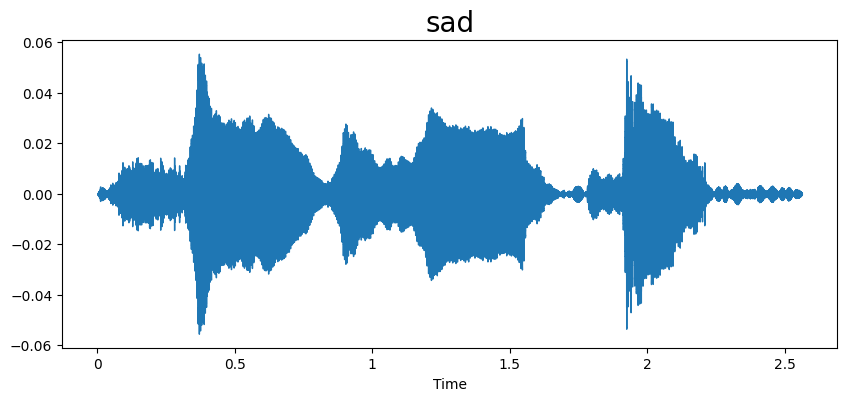

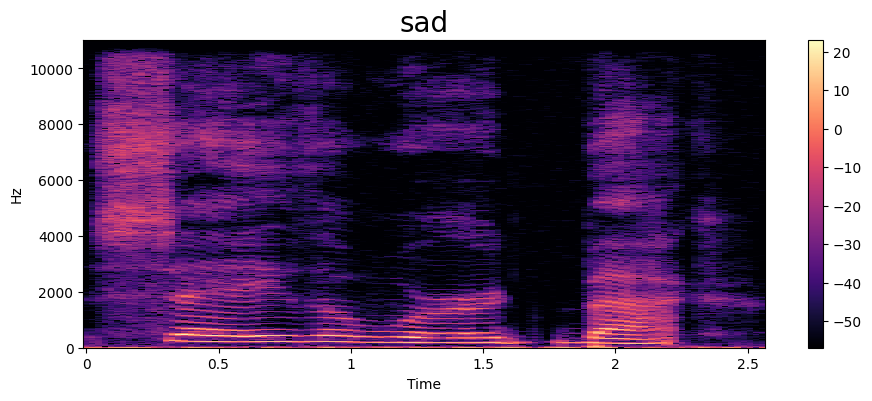

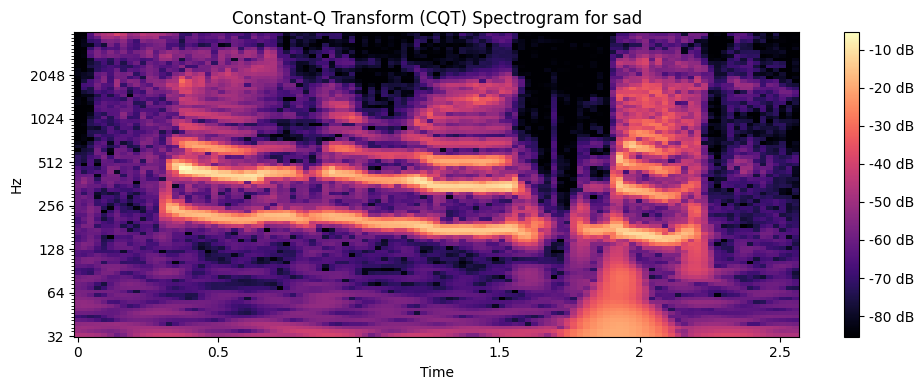

In [23]:
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
cqt_spectogram(path, emotion)
Audio(path)

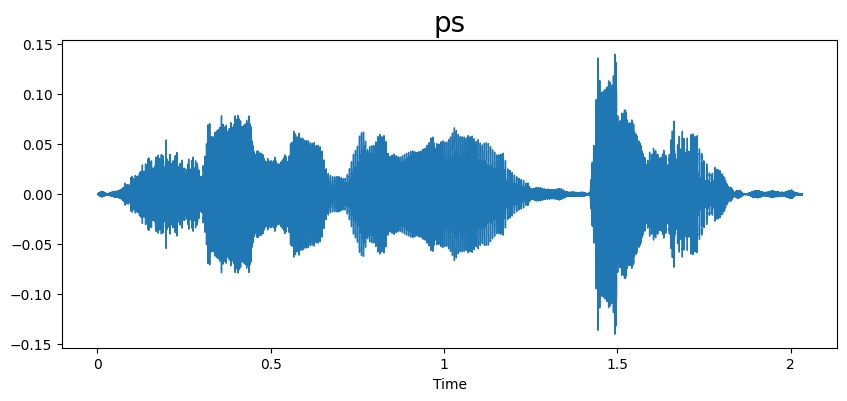

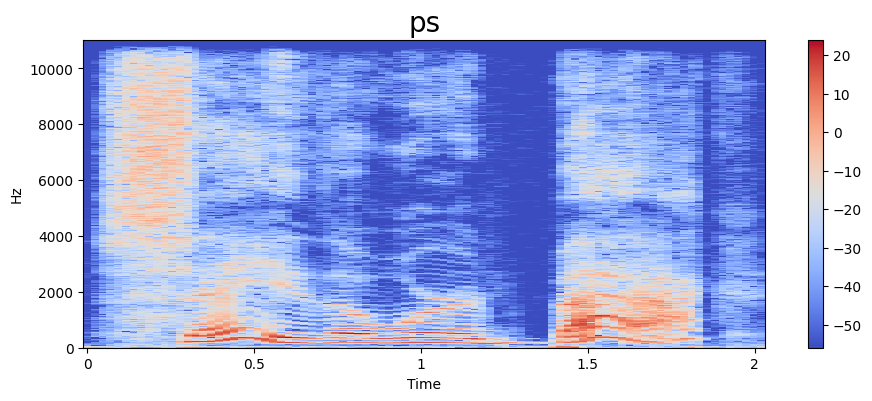

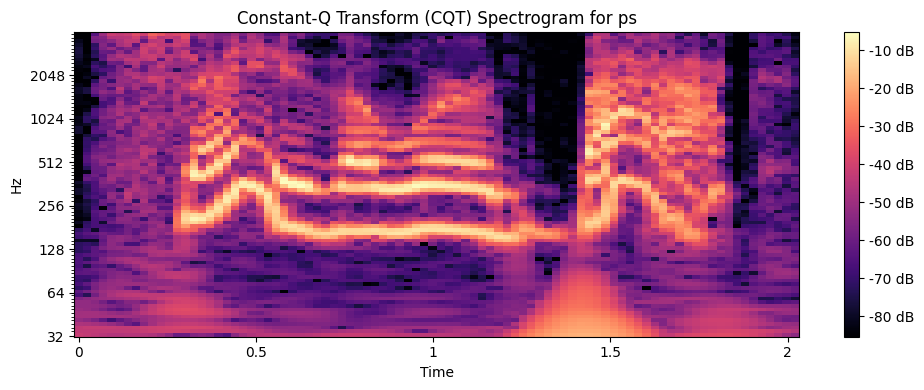

In [24]:
emotion = 'ps'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
cqt_spectogram(path, emotion)
Audio(path)

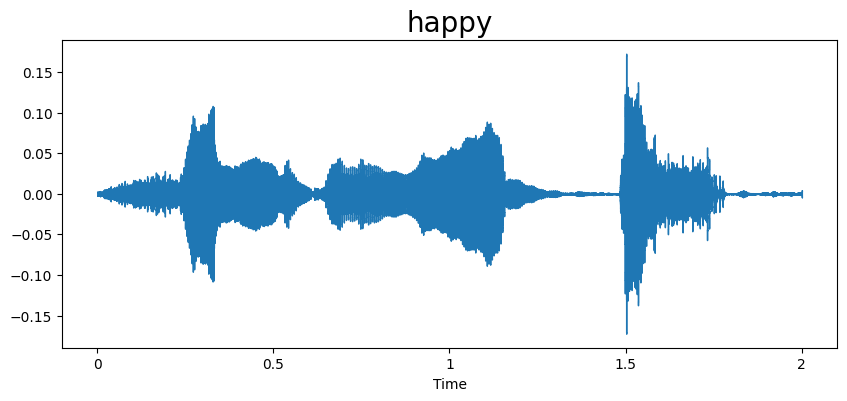

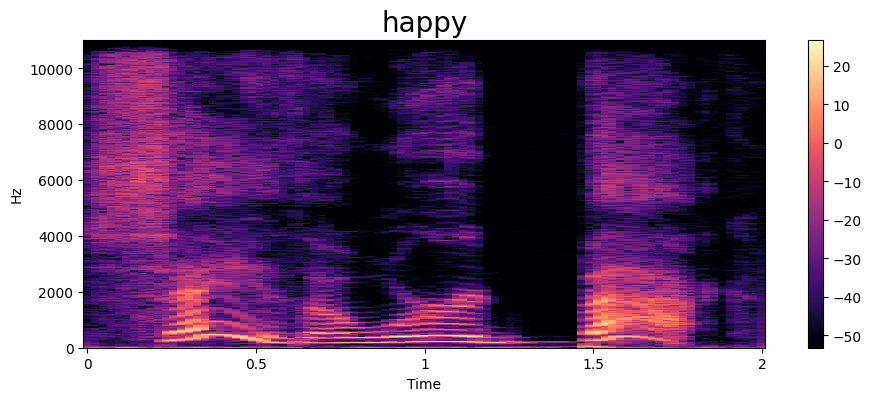

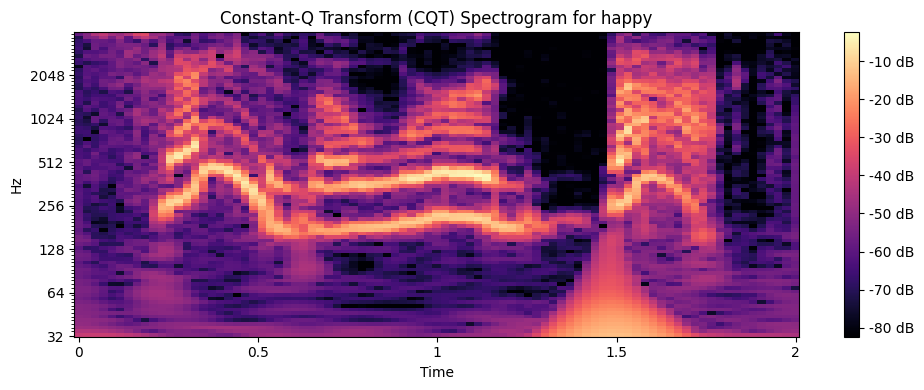

In [25]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
cqt_spectogram(path, emotion)
Audio(path)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(np.array(data_array), labels_categorical, test_size=0.2, random_state=42)

In [27]:
if len(X_train.shape) == 2:
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # Reshape to (samples, time_steps, features)
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

X_train.shape[0]

2236

In [28]:
import numpy as np
import joblib

# Save X_train
np.save("X_train_ser.npy", X_train)

# Save label encoder
joblib.dump(label_encoder, "label_encoder_ser.pkl")

['label_encoder_ser.pkl']

In [29]:
model = Sequential([
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.4),
    BatchNormalization(),

    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    BatchNormalization(),
    
    LSTM(32, kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    BatchNormalization(),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(y_train.shape[1], activation='softmax')
])


In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

In [23]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step - accuracy: 0.1543 - loss: 2.6734 - val_accuracy: 0.2057 - val_loss: 2.2969 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.2000 - loss: 2.3582 - val_accuracy: 0.3721 - val_loss: 2.1475 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.2993 - loss: 2.0988 - val_accuracy: 0.5098 - val_loss: 1.8347 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.4288 - loss: 1.8067 - val_accuracy: 0.5635 - val_loss: 1.5295 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.5369 - loss: 1.5165 - val_accuracy: 0.6923 - val_loss: 1.2499 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.6224 - loss: 1.3168 - val_accuracy: 0.7084 - val_loss: 1.1461 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.7029 - los

In [29]:
model = tf.keras.models.load_model('serXAI.h5')

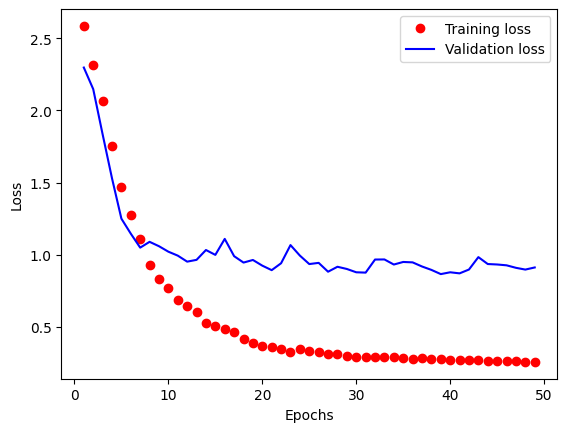

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range (1,len(loss)+1)

plt.plot(epochs,loss,'ro',label='Training loss')
plt.plot(epochs , val_loss ,'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

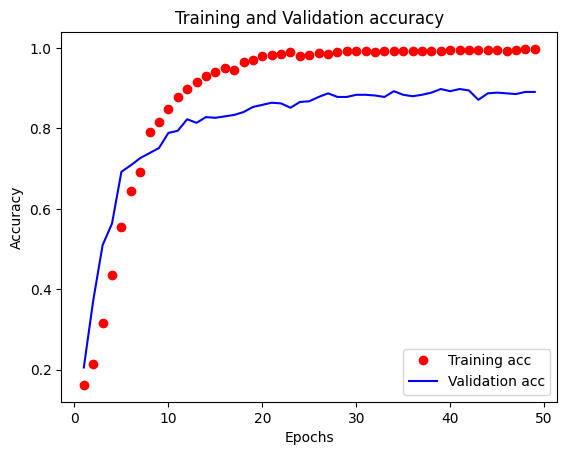

In [25]:
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

plt.plot(epochs,acc,'ro',label='Training acc')
plt.plot(epochs , val_acc ,'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
features = extract_features(r'C:\Users\adhin\OneDrive\Desktop\SER\TESS Toronto emotional speech set data\OAF_angry\OAF_which_angry.wav')
features.shape[1]

68

18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 870ms/step


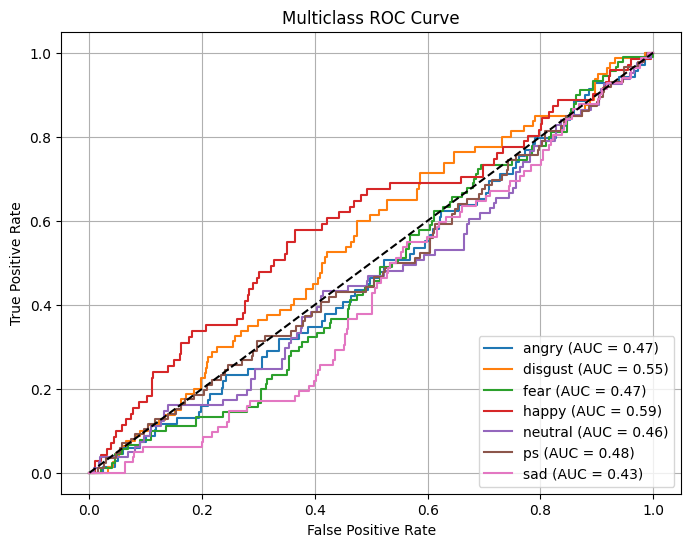

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
def plot_multiclass_roc(y_true, y_pred_probs, class_names):
    """
    y_true: shape (n_samples,) with class indices (0, 1, ..., n_classes-1)
    y_pred_probs: shape (n_samples, n_classes) softmax outputs
    class_names: list of class labels
    """
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Multiclass ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

y_pred_probs = model.predict(X_val)  # shape: (n_samples, n_classes)

# True labels: e.g., y_test = [0, 2, 1, ...]
plot_multiclass_roc(y_val, y_pred_probs, class_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad'])

In [27]:
def predict(wav_file_name):
    # Load the audio file and extract features
    features = extract_features(wav_file_name)
    
    # Padding or trimming to match the input shape
    if features.shape[1] < max_features:
        features = np.pad(features, ((0, 0), (0, max_features - features.shape[1])), 'constant')
    else:
        features = features[:, :max_features]  # Trim if longer
    
    # Reshape to match model's input (samples, time_steps, features)
    features = np.expand_dims(features, axis=0)
    if len(features.shape) == 2:
        features = features.reshape((features.shape[0], features.shape[1], 1))
    
    # Ensure the input shape is correct
    expected_shape = (1, X_train.shape[1], X_train.shape[2])
    if features.shape != expected_shape:
        print(f"Reshaping the input to the expected shape: {expected_shape}")
        features = np.reshape(features, expected_shape)
    
    # Predict the emotion
    prediction = model.predict(features)
    predicted_label = np.argmax(prediction)
    emotion = label_encoder.inverse_transform([predicted_label])[0]
    print(f"Predicted Emotion: {emotion}")
    
    # Explainable AI with LIME
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train.reshape((X_train.shape[0], -1)),  # Reshape for LIME compatibility
        feature_names=[f'feature_{i}' for i in range(X_train.shape[1] * X_train.shape[2])],
        class_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad'],
        verbose=True,
        mode='classification'
    )
    
    # Reshape the input for LIME explanation
    instance = features.reshape(1, -1)
    explanation = explainer.explain_instance(
        instance[0],
        lambda x: model.predict(x.reshape((-1, X_train.shape[1], X_train.shape[2]))),
        num_features=10,
        top_labels=1
    )
    explanation.show_in_notebook(show_all=False)

    return emotion

# Evaluate the model
evaluation = model.evaluate(X_val, y_val, verbose=2)
print(f"Validation Loss: {evaluation[0]}, Validation Accuracy: {evaluation[1]}")
predict(r'C:\Users\adhin\OneDrive\Desktop\SER\TESS Toronto emotional speech set data\YAF_angry\YAF_back_angry.wav')

18/18 - 1s - 44ms/step - accuracy: 0.8980 - loss: 0.8659
Validation Loss: 0.8659054636955261, Validation Accuracy: 0.8980321884155273
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
Predicted Emotion: angry
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step
Intercept 0.20182588256091044
Prediction_local [0.51589967]
Right: 0.9999205


'angry'

In [28]:
predict(r'C:\Users\adhin\OneDrive\Desktop\SER\SER\Actor_04\03-01-01-01-01-02-04.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Emotion: disgust
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step
Intercept 0.12489673128302335
Prediction_local [0.26229218]
Right: 0.99966


'disgust'

In [29]:
predicted_probs = model.predict(X_val)
predicted_classes = np.argmax(predicted_probs, axis=1)
true_labels = y_val
true_labels = np.argmax(true_labels, axis=1) 
precision = precision_score(true_labels, predicted_classes, average='weighted')
recall = recall_score(true_labels, predicted_classes, average='weighted')
f1 = f1_score(true_labels, predicted_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
Precision: 0.9007784251729736
Recall: 0.8980322003577818
F1-Score: 0.8985108100290528


In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 124, 64)        │        89,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 124, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 124, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 124, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 124, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 124, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 413,335 (1.58 MB)

 Trainable params: 137,671 (537.78 KB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 275,344 (1.05 MB)

In [31]:
model.save('serXAI.h5')

In [39]:
modelc= tf.keras.models.load_model('serXAI.h5')